## Example: running the Higher Order Dynamic Mode Decomposition (HODMD) model

This notebook will walk through an example of running the HODMD model in DTBase, using some synthetic temperature and humidity data.

In [1]:
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Generating and uploading the synthetic data

We will create (if it's not already there) a couple of dummy sensors called "TRH1" and "TRH2" that measure Temperature and Relative Humidity, and some synthetic sensor readings for them, going back 100 days from the current time.

In [2]:
from dtbase.core.utils import get_db_session
from dtbase.tests.upload_synthetic_data import insert_trh_readings

In [3]:
session = get_db_session()
insert_trh_readings(session, sensor_unique_id="TRH1")
insert_trh_readings(session, sensor_unique_id="TRH2")

Inserted 14394 temperature values
Inserted 14394 temperature values


### Fetching and cleaning the training data

In [5]:

from dtbase.models.hodmd.run_pipeline import fetch_data

from pydmd import HODMD
from pydmd.plotter import plot_eigs
from pydmd import ModesTuner



In [6]:
def plot_data(xtrain_label, xtrain, xtest_label, xtest, plot_label):
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(xtrain_label, xtrain, label=[label + '_train' for label in plot_label])
    ax.plot(xtest_label, xtest, label=[label + '_test' for label in plot_label])
    ax.legend(loc='best')
    fig.show()

In [7]:
data = fetch_data()
print(data.keys())

Training data from 2023-04-23 14:37:54.456281 to 2023-06-22 14:37:54.456281


INFO:dtbase.models.utils.dataprocessor.clean_data:Cleaning sensor data...
INFO:dtbase.models.utils.dataprocessor.clean_data:Done cleaning sensor data.
INFO:dtbase.models.utils.dataprocessor.clean_data:Cleaning sensor data...
INFO:dtbase.models.utils.dataprocessor.clean_data:Done cleaning sensor data.
INFO:dtbase.models.utils.dataprocessor.prepare_data:Preparing the data to feed to the model...
INFO:dtbase.models.utils.dataprocessor.prepare_data:Done preparing the data. Ready to feed to the model.


dict_keys(['TRH1'])


In [8]:
data['TRH1']

,Temperature,Humidity
timestamp,,
2023-04-23 15:00:00+00:00,20.830827,54.218907
2023-04-23 16:00:00+00:00,21.652546,60.364648
2023-04-23 17:00:00+00:00,22.395138,62.772292
2023-04-23 18:00:00+00:00,22.936518,63.329968
2023-04-23 19:00:00+00:00,23.467367,66.388578
...,...,...
2023-06-22 00:00:00+00:00,23.970216,65.743302
2023-06-22 01:00:00+00:00,22.991696,63.065791
2023-06-22 02:00:00+00:00,22.340714,60.248835


In [9]:
legends = data['TRH1'].columns.tolist()
xdata_label = data['TRH1'].index.values
xdata = data['TRH1'].values
print(xdata_label.shape)
print(xdata.shape) # num_samples x num_sensor_measures
num_train_samples = int(0.8 * len(xdata))

xtrain_label = xdata_label[ : num_train_samples]
xtrain = xdata[ : num_train_samples, : ]
xtest_label = xdata_label[num_train_samples : ]
xtest = xdata[num_train_samples : , : ]

(1430,)
(1430, 2)


### Visualise the training and test data

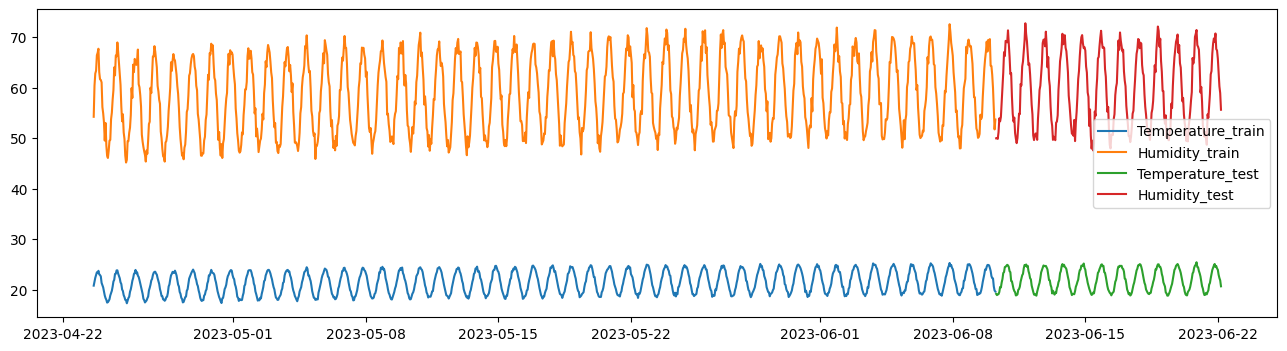

In [10]:
plot_data(xtrain_label, xtrain, xtest_label, xtest, legends)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=True, with_mean=True, copy=True)
scaler = scaler.fit(xtrain)
xtrain_normalized = scaler.transform(xtrain)
xtest_normalized = scaler.transform(xtest)

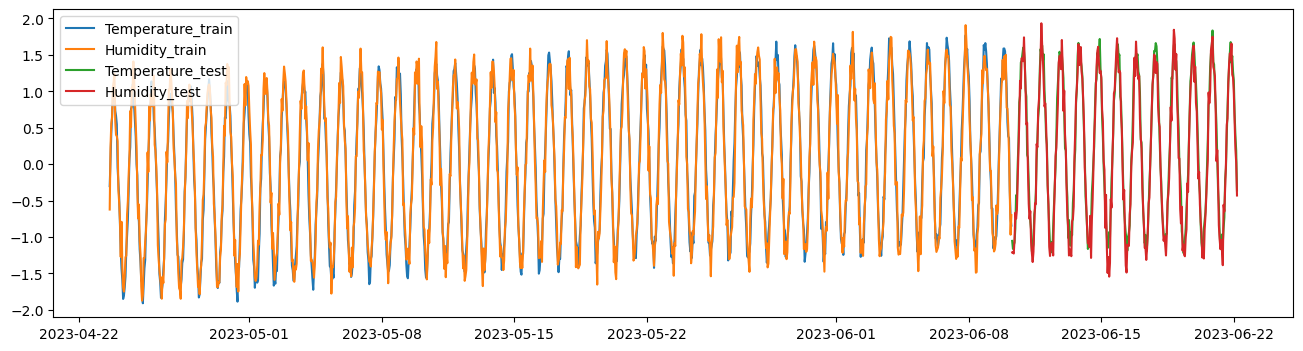

In [12]:
plot_data(xtrain_label, xtrain_normalized, xtest_label, xtest_normalized, legends)

In [13]:
snapshots = xtrain_normalized.T
print(snapshots.shape)

(2, 1144)


### Run and validate the HODMD model

INFO:root:Snapshots: (2, 1144), snapshot shape: (2,)
INFO:root:Snapshots: (1, 1144), snapshot shape: (1,)
INFO:root:Snapshots: (250, 895), snapshot shape: (250,)
INFO:root:Snapshots: (250, 895), snapshot shape: (250,)


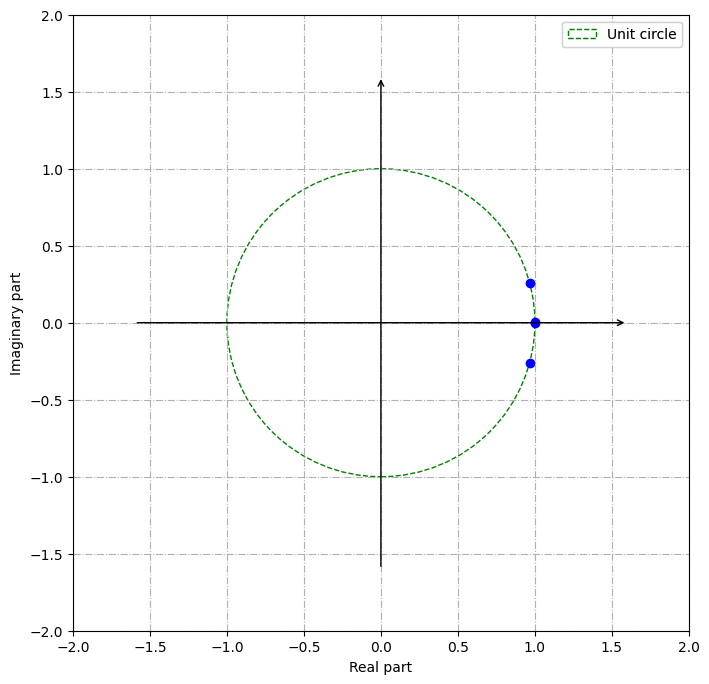

In [14]:
hodmd = HODMD(svd_rank = 0.99, svd_rank_extra = 0.9, exact = True, opt = True, d = 250, forward_backward = True, sorted_eigs = 'real').fit(snapshots)
plot_eigs(hodmd, show_axes=True, show_unit_circle=True)
hodmd.dmd_time['tend'] = len(xdata) - 1


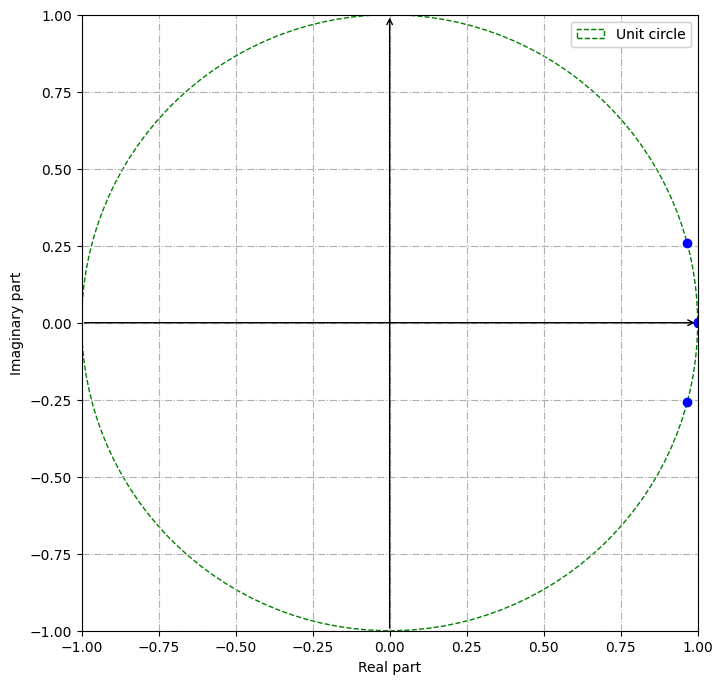

In [15]:
'''
=========================================================
DMD Mode truncation
=========================================================
'''

mtuner = ModesTuner(hodmd)
mtuner.select('integral_contribution', n=50)
#mtuner.select('stable_modes',max_distance_from_unity=1.e-3)
mtuner.stabilize(inner_radius=0.5, outer_radius=1.5)
tunedDMD= mtuner._dmds[0]
hodmd = tunedDMD

plot_eigs(hodmd, show_axes=True, show_unit_circle=True)

In [16]:
xreconstructed = hodmd.reconstructed_data.real
print(xreconstructed.shape)

(2, 1430)


In [17]:
print(xdata.shape)
print(xtrain_normalized.shape)

(1430, 2)
(1144, 2)


### Plot the model predictions

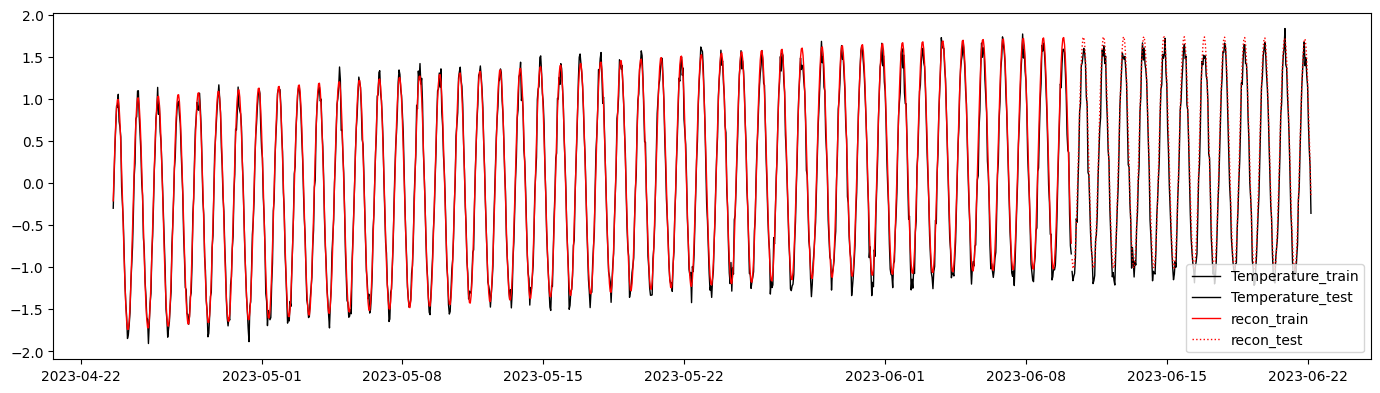

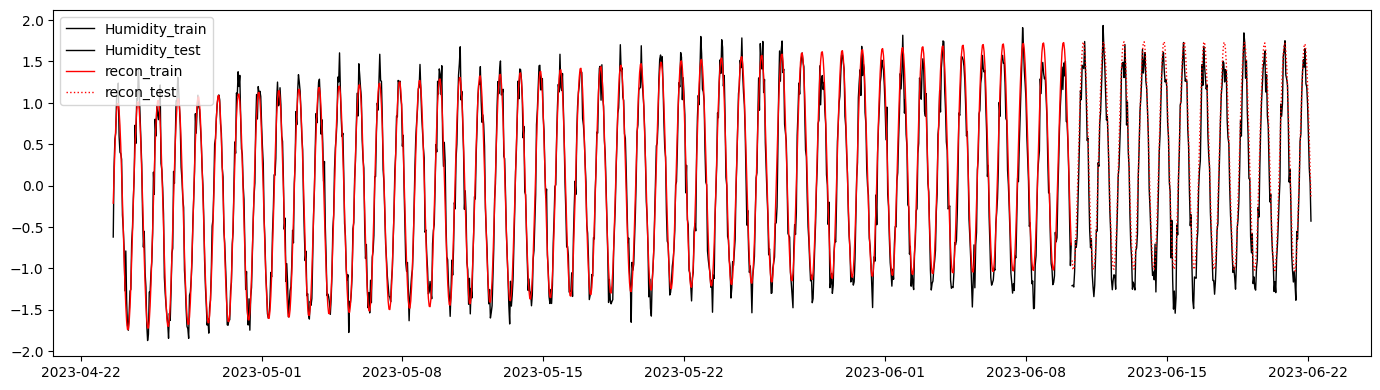

In [18]:
for idx, legend in enumerate(legends):
    fig, ax = plt.subplots(figsize=(17, 4.5))
    ax.plot(xtrain_label, xtrain_normalized[ : , idx], label=legend + '_train', c='k', linewidth = 1)
    ax.plot(xtest_label, xtest_normalized[ : , idx], label=legend + '_test', c='k', linewidth = 1)
    ax.plot(xtrain_label, xreconstructed[idx, : num_train_samples].T, label='recon_train', c='r', linewidth = 1)
    ax.plot(xtest_label, xreconstructed[idx, num_train_samples : ].T, ':', label='recon_test', c='r', linewidth = 1)
    ax.legend(loc='best')
    fig.show()